# CTA 2D source fitting with Sherpa


## Prepare sky images
We first create counts, exposure, background and PSF maps, following the steps under "Make sky images" in the cta_data_analysis Notebook:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
import astropy.units as u
from gammapy.image import SkyImage, IACTBasicImageEstimator
from gammapy.background import RingBackgroundEstimator
from gammapy.data import DataStore

from regions import CircleSkyRegion
import numpy as np

# Create reference image: 6x6 deg FOV centered on (l,b) = (300,0)
target_position = SkyCoord(299, 0, unit='deg', frame='galactic')

xref = target_position.galactic.l.value
yref = target_position.galactic.b.value

ref_image = SkyImage.empty(
    nxpix=200, nypix=150, binsz=0.02,
    xref=xref, yref=yref,
    proj='TAN', coordsys='GAL')

We initially define no exclusion regions for the background estimation, as we have not yet determined the positions of sources in the field of view:

Name: None
Data shape: (150, 200)
Data type: bool
Data unit: 
Data mean: 9.341e-01
WCS type: ['GLON-TAN', 'GLAT-TAN']



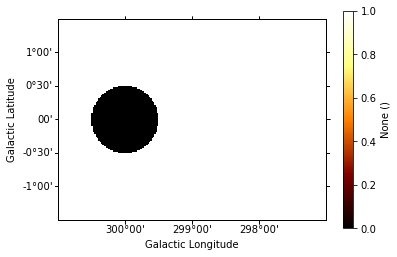

In [2]:
on_region = CircleSkyRegion(center=SkyCoord(300, 0, unit='deg',
                            frame='galactic'), radius=0.5 * u.deg)
excl_mask = ref_image.region_mask(on_region)
excl_mask.data = np.invert(excl_mask.data)

# excl_mask = ref_image
# excl_mask.data = ref_image.data == 0

print(excl_mask)
excl_mask.plot(add_cbar=True)

bkg_estimator = RingBackgroundEstimator(
    r_in=0.5 * u.deg,
    width=0.2 * u.deg)

Set the map energy threshold at 300 GeV, which seems a good compromise for source detection sensitivity: with a low threshold the background is more important, but too high a threshold yields limited source statistics.

In [3]:
image_estimator = IACTBasicImageEstimator(
    reference=ref_image,
    emin=0.3 * u.TeV,
    emax=100 * u.TeV,
    offset_max=4 * u.deg,
    background_estimator=bkg_estimator,
    exclusion_mask=excl_mask)

OBS_ID
------
110040
110122
110120
110119
110081
110078
110121
110079
110080
110038
110037
110039 observations within radius 4 deg


/Users/facero/Documents/Work/Program/gammapy/gammapy/gammapy/cube/core.py:85: RuntimeWarning: divide by zero encountered in log
  log_data = np.log(self.data.value)
/Users/facero/Documents/Work/Program/Anaconda/envs/cta/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:2444: RuntimeWarning: invalid value encountered in multiply
  values += np.asarray(self.values[edge_indices]) * weight[vslice]


counts


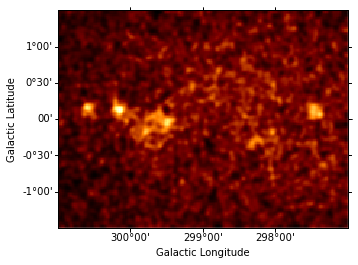

exposure


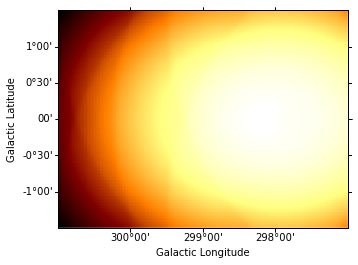

background


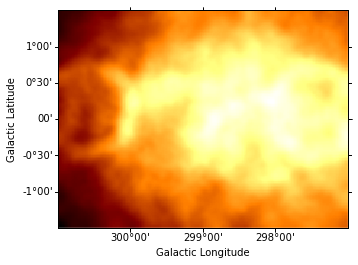

excess


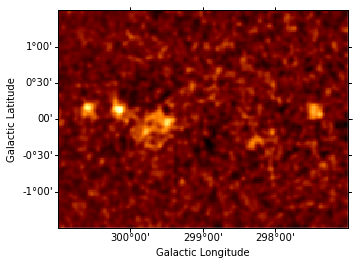

flux


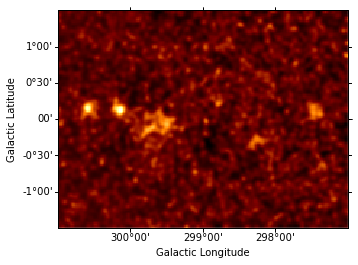

psf


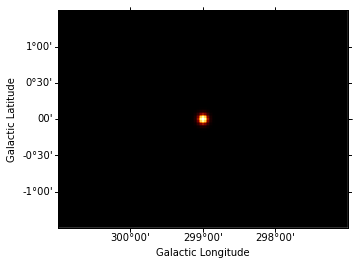

In [4]:
# Point to data challenge simulation directory
INDX_DIR = '../handson/index/gps'

data_store = DataStore.from_dir(INDX_DIR)

ras = data_store.obs_table['RA_PNT'] * u.deg
decs = data_store.obs_table['DEC_PNT'] * u.deg
pointings = SkyCoord(ras, decs, frame='icrs' )
dists = pointings.separation(target_position)
obs_id = data_store.obs_table['OBS_ID'][(dists < 4 * u.deg)]
print((obs_id), "observations within radius 4 deg")

obslist = data_store.obs_list(obs_id)
images = image_estimator.run(obslist)

for i,im in enumerate(images):
    print(images.names[i])
    im.smooth(radius=3).plot() ; plt.show()

Now save the obtained images as FITS files for import into Sherpa:

In [5]:
images['counts']    .write("G300-0_test_counts.fits", clobber=True)
images['exposure']  .write("G300-0_test_exposure.fits", clobber=True)
images['background'].write("G300-0_test_background.fits", clobber=True)

#As psf is an array of quantities we cannot use the images['psf'].write() function
#all the other arrays do not have quantities. To investigate
fits.writeto("G300-0_test_psf.fits",images['psf'].data.value,overwrite=True)



## Fit sources with Sherpa
Set up Sherpa to fit the counts map, loading the ancillary images for subsequent use. A relevant test statistic for data with Poisson fluctuations is the one proposed by Cash (1979). The simplex (or Nelder-Mead) fitting algorithm is a good compromise between efficiency and robustness. The source fit is best performed in pixel coordinates.

In [6]:
import sherpa.astro.ui as sh
from gammapy.image import SkyImage
from regions.core.pixcoord import PixCoord
from regions.shapes.circle import CirclePixelRegion

sh.set_stat("cash")
sh.set_method("simplex")
sh.load_image("G300-0_test_counts.fits")
sh.set_coord("logical")

sh.load_table_model("expo", "G300-0_test_exposure.fits")
sh.load_table_model("bkg",  "G300-0_test_background.fits")
sh.load_psf        ("psf",  "G300-0_test_psf.fits")

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find xpaget on your PATH'


In principle one might first want to fit the background amplitude. However the background estimation method already yields the correct normalization, so we freeze the background amplitude to unity instead of adjusting it. The (smoothed) residuals from this background model are then computed and shown.

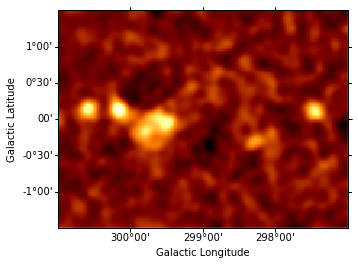

In [7]:
sh.set_full_model(bkg)
bkg.ampl = 1
sh.freeze(bkg)

data = sh.get_data_image().y -  sh.get_model_image().y
resid = SkyImage(data=data, wcs=ref_image.wcs)

resid_table=[]  #Keep residual images in a list to show them later
resid_smo6 = resid.smooth(radius = 6)
resid_smo6.plot()
resid_table.append(resid_smo6)

### Find and fit the brightest source
We then find the position of the maximum in the (smoothed) residuals map, and fit a (symmetrical) Gaussian source with that initial position:

In [8]:
maxcoord = resid_smo6.lookup_max()
maxpix = resid_smo6.wcs_skycoord_to_pixel(maxcoord[0])
sh.set_full_model(bkg + psf(sh.gauss2d.g0) * expo) # creates g0 as a gauss2d instance
g0.xpos = maxpix[0]
g0.ypos = maxpix[1]
sh.freeze(g0.xpos, g0.ypos) # fix the position in the initial fitting step

expo.ampl = 1e-9 # fix exposure amplitude so that typical exposure is of order unity
sh.freeze(expo)
sh.thaw(g0.fwhm, g0.ampl) # in case frozen in a previous iteration

g0.fwhm = 10 # give some reasonable initial values
g0.ampl = maxcoord[1]
sh.fit() # Performs the fit; this takes a little time.

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47907.2
Final fit statistic   = 47503 at function evaluation 234
Data points           = 30000
Degrees of freedom    = 29998
Change in statistic   = 404.211
   g0.fwhm        6.43418     
   g0.ampl        0.400131    


Fit all parameters of this Gaussian component, fix them and re-compute the residuals map.

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47503
Final fit statistic   = 47498.4 at function evaluation 354
Data points           = 30000
Degrees of freedom    = 29996
Change in statistic   = 4.57486
   g0.fwhm        6.33581     
   g0.xpos        41.9218     
   g0.ypos        81.3048     
   g0.ampl        0.417545    


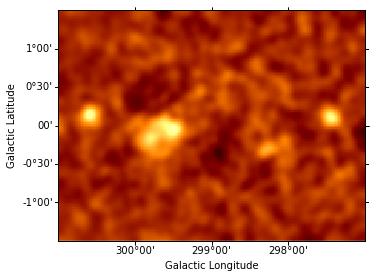

In [9]:
sh.thaw(g0.xpos, g0.ypos)
sh.fit()
sh.freeze(g0)

data = sh.get_data_image().y -  sh.get_model_image().y
resid = SkyImage(data=data, wcs=ref_image.wcs)

resid_smo6 = resid.smooth(radius = 6)
resid_smo6.show(vmin = -0.5, vmax = 1)
resid_table.append(resid_smo6)

### Iteratively find and fit additional sources
Instantiate additional Gaussian components, and use them to iteratively fit sources, repeating the steps performed above for component g0. (The residuals map is shown after each additional source included in the model.) This takes some time...

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47498.4
Final fit statistic   = 47335 at function evaluation 269
Data points           = 30000
Degrees of freedom    = 29998
Change in statistic   = 163.402
   g1.fwhm        19.8613     
   g1.ampl        0.100529    
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47335
Final fit statistic   = 47293.7 at function evaluation 394
Data points           = 30000
Degrees of freedom    = 29996
Change in statistic   = 41.3431
   g1.fwhm        19.9265     
   g1.xpos        67.2544     
   g1.ypos        69.3013     
   g1.ampl        0.116012    


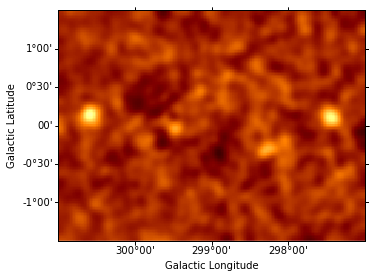

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47293.7
Final fit statistic   = 47185.5 at function evaluation 264
Data points           = 30000
Degrees of freedom    = 29998
Change in statistic   = 108.124
   g2.fwhm        6.20212     
   g2.ampl        0.393345    
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47185.5
Final fit statistic   = 47182.5 at function evaluation 342
Data points           = 30000
Degrees of freedom    = 29996
Change in statistic   = 3.05173
   g2.fwhm        6.19309     
   g2.xpos        20.8274     
   g2.ypos        81.6413     
   g2.ampl        0.40001     


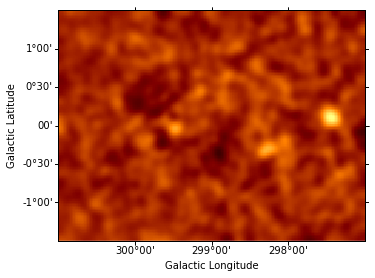

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47182.5
Final fit statistic   = 47115 at function evaluation 275
Data points           = 30000
Degrees of freedom    = 29998
Change in statistic   = 67.4731
   g3.fwhm        6.43218     
   g3.ampl        0.235481    
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47115
Final fit statistic   = 47114.3 at function evaluation 303
Data points           = 30000
Degrees of freedom    = 29996
Change in statistic   = 0.728928
   g3.fwhm        6.38175     
   g3.xpos        177.458     
   g3.ypos        80.2233     
   g3.ampl        0.239637    


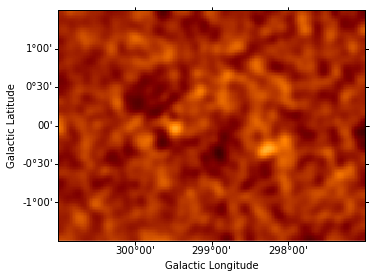

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47114.3
Final fit statistic   = 47086.6 at function evaluation 277
Data points           = 30000
Degrees of freedom    = 29998
Change in statistic   = 27.7341
   g4.fwhm        5.70151     
   g4.ampl        0.162191    
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47086.6
Final fit statistic   = 47085.7 at function evaluation 304
Data points           = 30000
Degrees of freedom    = 29996
Change in statistic   = 0.898776
   g4.fwhm        5.94179     
   g4.xpos        135.942     
   g4.ypos        59.5875     
   g4.ampl        0.156213    


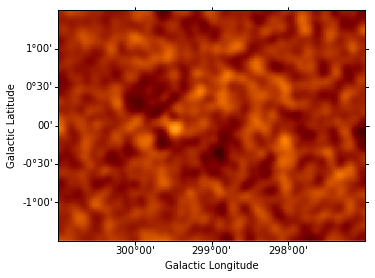

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47085.7
Final fit statistic   = 47069 at function evaluation 262
Data points           = 30000
Degrees of freedom    = 29998
Change in statistic   = 16.6424
   g5.fwhm        2.82885     
   g5.ampl        0.52359     
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47069
Final fit statistic   = 47068.9 at function evaluation 328
Data points           = 30000
Degrees of freedom    = 29996
Change in statistic   = 0.0749129
   g5.fwhm        2.82317     
   g5.xpos        76.1381     
   g5.ypos        73.1869     
   g5.ampl        0.524268    


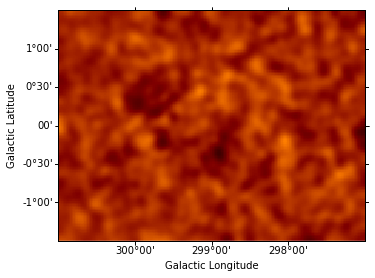

In [10]:
for i in range(1,6) :
    sh.create_model_component('gauss2d', 'g'+str(i))
gs = [g0, g1, g2, g3, g4, g5]
sh.set_full_model(bkg + psf(g0+g1+g2+g3+g4+g5) * expo)

for i in range(1, len(gs)) :
    gs[i].ampl = 0   # initialize components with fixed, zero amplitude
    sh.freeze(gs[i])

for i in range(1, len(gs)) :
    maxcoord = resid_smo6.lookup_max()
    maxpix = resid_smo6.wcs_skycoord_to_pixel(maxcoord[0])
    gs[i].xpos = maxpix[0]
    gs[i].ypos = maxpix[1]
    gs[i].fwhm = 10
    gs[i].fwhm = maxcoord[1]

    sh.thaw(gs[i].fwhm)
    sh.thaw(gs[i].ampl)
    sh.fit()

    sh.thaw(gs[i].xpos)
    sh.thaw(gs[i].ypos)
    sh.fit()
    sh.freeze(gs[i])

    data = sh.get_data_image().y -  sh.get_model_image().y
    resid = SkyImage(data=data, wcs=ref_image.wcs)

    resid_smo6 = resid.smooth(radius = 6)
    resid_smo6.show(vmin = -0.5, vmax = 1)
    resid_table.append(resid_smo6)

The criterion for a significant source detection is typically that it should improve the test statistic by at least 25 or 30. The last excess fitted (g5) thus not a significant source:

In [11]:
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.table import Table

pix_scale = ref_image.wcs_pixel_scale()[0].deg


rows = []
for idx, g in enumerate(gs):
    ampl = g.ampl.val
    g.ampl = 0
    stati = sh.get_stat_info()[0].statval
    g.ampl = ampl
    statf = sh.get_stat_info()[0].statval
    delstat = stati - statf
    
    coord = resid.wcs_pixel_to_skycoord(g.xpos.val, g.ypos.val)
    pix_scale = resid.wcs_pixel_scale()[0].deg
    sigma = g.fwhm.val * pix_scale * gaussian_fwhm_to_sigma
    rows.append(dict(
        idx=idx,
        delstat=delstat,
        glon=coord.l.deg,
        glat=coord.b.deg,
        sigma=sigma ,
    ))

table = Table(rows=rows, names=rows[0])
table[table['delstat'] > 25]

idx,delstat,glon,glat,sigma
int64,float64,float64,float64,float64
0,136.582187364,300.151408614,0.136068174452,0.0538113987742
1,158.744570772,299.644884821,-0.103966965279,0.169240266293
2,111.176173057,300.57305638,0.142771893381,0.0525992264273
3,68.2020558775,297.441233657,0.114422638212,0.0542015591058
4,28.632872396,298.27120691,-0.298223927544,0.0504649169514


In [14]:
from ipywidgets.widgets.interaction import interact

def plot_resid(i):
    resid_table[i].plot(vmin=-0.5, vmax=1)
    ax=plt.gca()
    ax.set_title('CStat=%.2f'%(table['delstat'][i]))
    ax.scatter(
    table['glon'][i], table['glat'][i],
    transform=ax.get_transform('galactic'),
    color='none', edgecolor='azure', marker='o', s=400)
    plt.show()
interact(plot_resid,i=(0,5))

<function __main__.plot_resid>